# DDPLKO Moduł 3 - praca domowa - pierwszy własny trening CNN

In [1]:
import urllib
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

plt.rcParams["figure.figsize"] = (20,10)
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# a = []
# while(1):
#     a.append("1")

# Wybierz 10 klas

Poniżej przygotuj listę 10 klas z:
https://quickdraw.withgoogle.com/data

> nazwy takie jak nazwy obiektów (wyświetlane po najechaniu lub kliknięciu)

In [3]:
class_names= ["butterfly","camel","bee","cow","crab","horse","octopus","penguin","rabbit","raccoon"]

## Test

In [4]:
assert len(class_names)==10, 'Nazw powinno być dokładnie 10'
for i in range(len(class_names)):
    assert type(class_names[i])==str, 'Każda z nazw powinna być typu str'
    assert '/' not in class_names[i], 'Same nazwy klas, ze spacjami, bez ukośników'

# Wczytanie danych
Pobieranie plików z obrazami w formaci npy (numpy)

In [5]:
for name in class_names:
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%name
    file_name = url.split('/')[-1].split('?')[0]

    url = url.replace(' ','%20')
    
    if not os.path.isfile(file_name):
        print(url, '==>', file_name)
        urllib.request.urlretrieve(url, file_name)

## Wczytywanie z plików .npy
Dane znajdziesz w tablicy data

In [6]:
data = []
for name in class_names:
    file_name = name+'.npy'
    data.append(np.load(file_name, fix_imports=True, allow_pickle=True))
    print('%-15s'%name,type(data[-1]))

butterfly       <class 'numpy.ndarray'>
camel           <class 'numpy.ndarray'>
bee             <class 'numpy.ndarray'>
cow             <class 'numpy.ndarray'>
crab            <class 'numpy.ndarray'>
horse           <class 'numpy.ndarray'>
octopus         <class 'numpy.ndarray'>
penguin         <class 'numpy.ndarray'>
rabbit          <class 'numpy.ndarray'>
raccoon         <class 'numpy.ndarray'>


In [7]:
#raise Exception() #zakomentować w przypadku użycia Tensorflow

# Liczebności i wymiary zdjęć
Wypisz nazwę i shape dla każdej klasy

In [8]:
for i,name in enumerate(class_names):
    print('%-15s'%name,data[i].shape)

butterfly       (117999, 784)
camel           (121399, 784)
bee             (120890, 784)
cow             (123083, 784)
crab            (126930, 784)
horse           (178286, 784)
octopus         (150152, 784)
penguin         (253791, 784)
rabbit          (155288, 784)
raccoon         (119588, 784)


Poniżej zwizualizuj liczbę zdjęć per klasę:

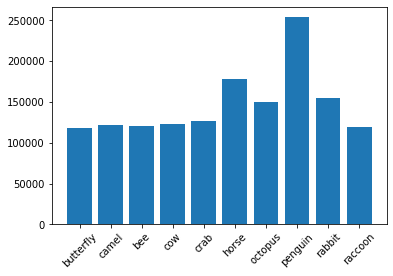

In [9]:
plt.bar(class_names, [_.shape[0] for _ in data])
plt.xticks(rotation=45);

# Wizualizacja danych
Dane są w macierzach dwuwyamirowych,
aby je poprawnie wyświetlić jako obraz,
należy je przekonwertować do 3 wymiarów:

- numer zdjęcia
- wysokość
- szerokość

Tu pomoże `reshape` z numpy.

## Konwersja do (-1, 28, 28)

In [10]:
data = [_.reshape(-1,28,28) for _ in data]

Wyświetl po jednym przykładzie z każdej klasy.

Możesz skorzystać z `plt.subplot`

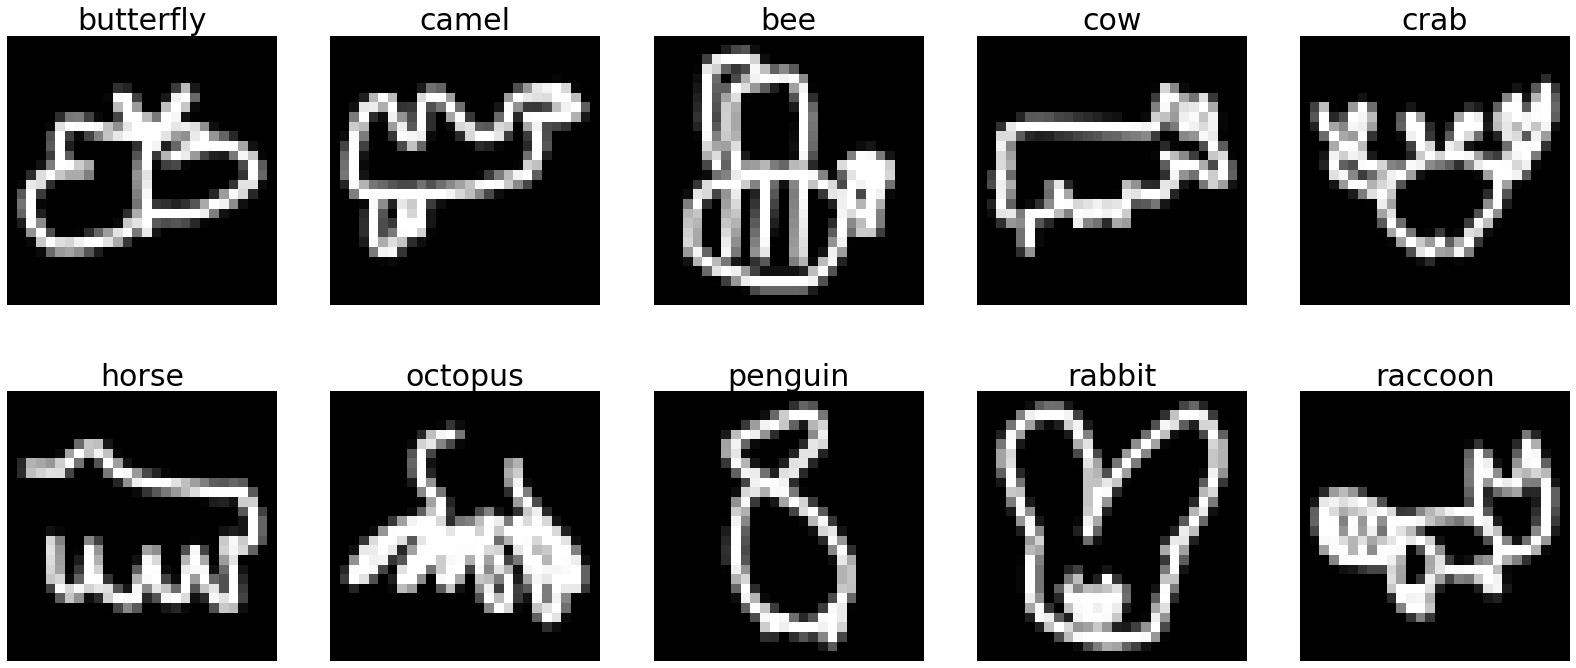

In [11]:
for i,_ in enumerate(data):
    np.random.shuffle(data[i])

plt.figure(figsize=(28,12))
for i, example in enumerate(data):
    plt.subplot(2,5,i+1)
    plt.title(class_names[i], fontsize=30)
    plt.imshow(example[i], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

## Obraz średni
Jak podobne do siebie są obrazy z poszczególnych klas?

Oblicz i wyświetl średni obraz dla wszystkich klas.

Możesz skorzystać z `np.mean`

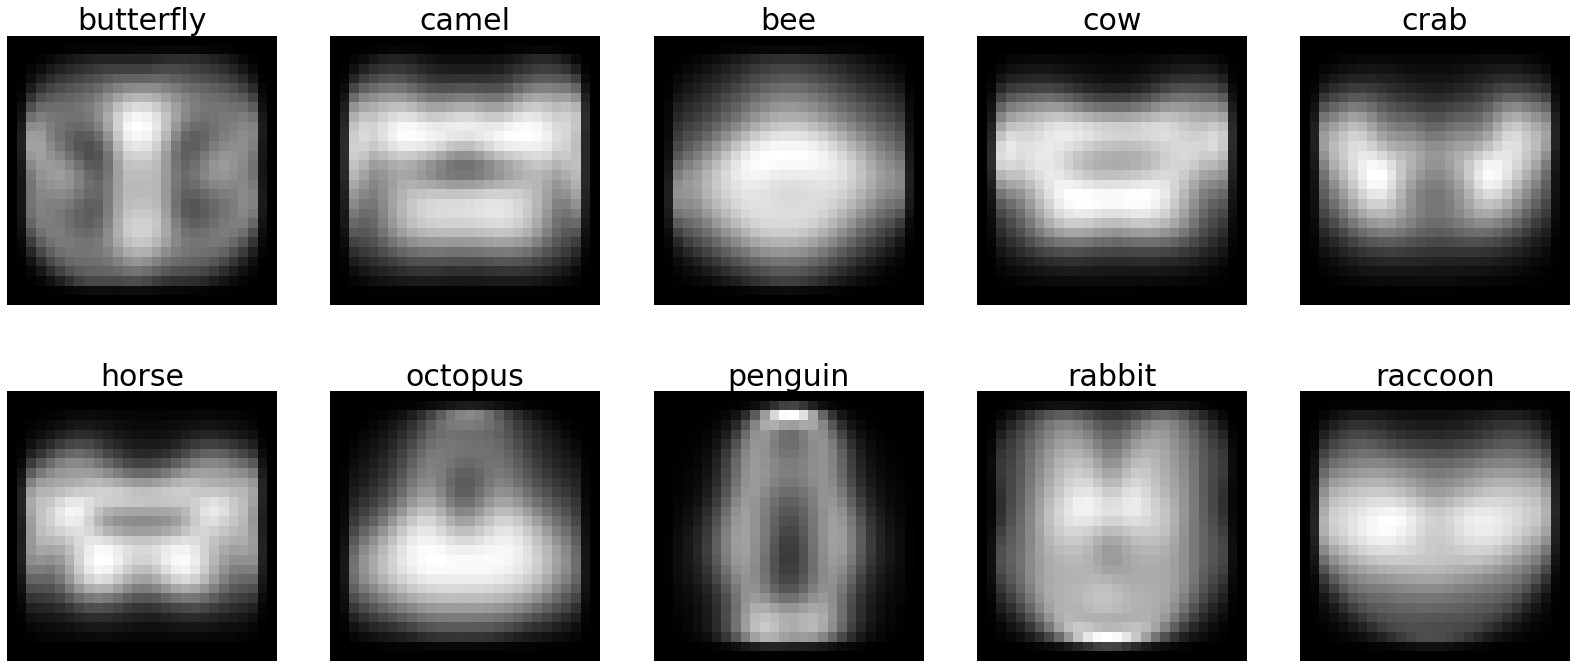

In [12]:
plt.figure(figsize=(28,12))
for i,class_element in enumerate(data):
    plt.subplot(2,5,i+1)
    plt.title(class_names[i], fontsize=30)
    plt.imshow(np.mean(class_element,axis=0), cmap='gray')
    plt.axis('off')

# Trening w TensorFlow

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import tensorflow as tf
from tqdm.notebook import tqdm



# Przygotowanie danych
Przygotowanie listy etykiet oraz macierzy zdjęć
Przygotuj:
- [ ] X - jako macierz numpy w której będą wszystkie zdjęcia
- [ ] y - jako macierz numpy w której będą wszystkie etykiety (jako numer klasy)
- [ ] wykonaj reshape dla X do (-1,28,28,1)

Co może Ci się przydać:
- łączenie macierzy - np.concatenate
- mnożenie listy przez N zwraca listę z N-krotnie więcej elementami [0]*3 ==>> [0,0,0]
- konwersja listy do macierzy numpy - np.array([0,1,2,3])

Korzystając z pythonowych zapisów możesz to zrobić w jednej lini per zmienną, nie zapisuj w obu w jednej, bo to już nie będzie czytelne (tak, da się)

In [14]:
X = np.concatenate(data,axis=0)
X = np.array([_.reshape(28,28,1) for _ in X])
y = np.concatenate([[counter] * data[counter].shape[0] for counter, value in enumerate(data)],axis=0,dtype="int8")

## Test

In [15]:
assert type(X)==np.ndarray,                 "X powinno być macierzą numpy"
assert type(y)==np.ndarray,                 "y powinno być macierzą numpy"
assert len(X)==sum([len(_) for _ in data]), "X powinno mieć tyle samo przykładów ile jest w data"
assert len(y)==sum([len(_) for _ in data]), "Y powinno mieć tyle samo etykiet ile jest przykładów w data"
assert len(X.shape)==4,                     "X - Wymagane są 4 wymiary - index, wysokość, szerokość, głębokość"
assert len(y.shape)==1,                     "y - Wymagany jest 1 wymiar"
assert X.shape[1:]==(28,28,1),              "Zdjęcia powinny być 28x28x1"

## Normalizacja

Przygotuj dane (X) w taki sposób by wartości były bliskie zera.
W celu zachowania prostoty - podziel wartości przez 255, a nie przez najwyższą wartość.
Nie przesuwaj średniej do zera, i nie normalizuj odchylenia.

In [16]:
print("X (przed normalizacją): ",X.shape)
print("X min:",np.min(X))
print("X max:",np.max(X))

new_X = np.array([])

# float16 w przypadku problemów z RAM
X = np.true_divide(X,255,dtype="float32")

print("Po normalizacji:")
print("X min:",np.min(X))
print("X max:",np.max(X))

X (przed normalizacją):  (1467406, 28, 28, 1)
X min: 0
X max: 255
Po normalizacji:
X min: 0.0
X max: 1.0


### Test

In [17]:
assert np.max(X)<=1, "Największa wartość nie może być większa niż 1"
assert np.min(X)>=0, "Pracujmy w zakresie od 0..1"

## Podział zbioru danych

Podziel zbiór zachowując ten sam stosunek liczby klas w train i val.
Do podziału użyj `train_test_split` z `sklearn`.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
del X

### Wizualizacja podziału

Przygotuj wykres, który pokaże jak dane train i val sumują się dla poszczególnych klas (trening+val powinny być jako jeden słupek, sumarycznie wysokości słupka przed podziałem). Podpowiedź - stacked bar plot.
Przygotuj drugi wykres, który pokaże czy zbiór danych jest podzielony z zachowaniem stosunku liczebności poszczególnych klas (zachowanie procentowych udziałów klas w zbiorze).

In [19]:
def additional_plt_info(labels,y_label,title):
    blue_bar = mpatches.Patch(color='blue', label=labels[0])
    green_bar = mpatches.Patch(color='green', label=labels[1])
    plt.legend(handles=[blue_bar,green_bar])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel(y_label)

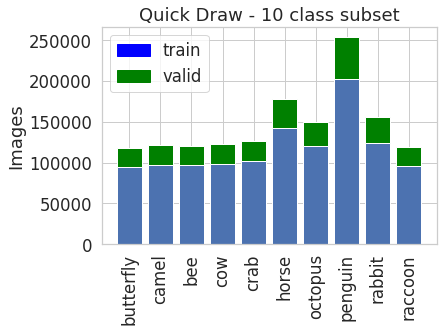

In [20]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


_, counts_train = np.unique(y_train, return_counts=True)
_, counts_valid = np.unique(y_val, return_counts=True)
plt.bar(class_names,counts_train)
plt.bar(class_names, counts_valid, bottom=counts_train, color='green');
additional_plt_info(labels=["train","valid"],y_label='Images',title="Quick Draw - 10 class subset")

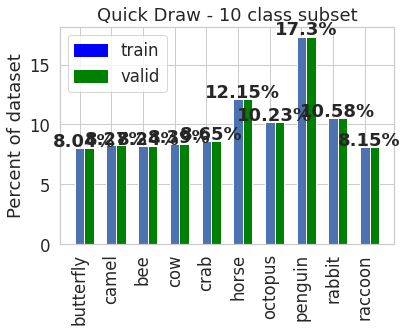

In [21]:
train_percentage = np.round(counts_train/sum(counts_train)*100,2)
valid_percentage = np.round(counts_valid/sum(counts_valid)*100,2)

width =0.3
train_graph = plt.bar(class_names, train_percentage, width=width)
valid_graph = plt.bar(np.arange(len(class_names))+ width, valid_percentage, width=width,color='green')
additional_plt_info(labels=["train","valid"],y_label='Percent of dataset',title="Quick Draw - 10 class subset")
i = 0
for p in train_graph:
    width = p.get_width()
    height = p.get_height()
    x2, y2 = p.get_xy()
    plt.text(x2+width/2*2,
             y2+height*1.01,
             str(train_percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

## Test podziału danych

In [22]:
assert all((np.unique(y_train, return_counts=True)[1]/len(y_train)).round(2) == (np.unique(y_val, return_counts=True)[1]/len(y_val)).round(2)), "Nierówny podział danych, zadbaj by rozkład w train i val były takie same"

# Przygotuj model

- Wykorzystaj warstwy konwolucyjne (minimum 1), pamiętaj o funkcjach aktywacji
- Wykorzystaj Flatten
- Model powinien mieć:
  - wejście 28,28,1
  - 10 wyjść
  - Adama jako optymalizator
  - sparse CE loss
  - warto dodać accuracy jako metrykę
  
Pooling wprowadzimy w module 4, a i bez niego uzyskasz >80% accuracy.

In [23]:
def getModel():
    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(8,(3,3), activation='relu',input_shape=(28, 28,1)),
                tf.keras.layers.Conv2D(16,(3,3), activation='relu'),
#                tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                92170     
Total params: 93,418
Trainable params: 93,418
Non-trainable params: 0
_________________________________________________________________


## Test

In [24]:
assert type(model)==tf.keras.models.Sequential, "Model powinien być tf.keras.models.Sequential"
assert model.compiled_loss is not None, "Skompiluj model"
assert model.loss == 'sparse_categorical_crossentropy', "Użyj jako loss 'sparse_categorical_crossentropy'"
assert model.count_params()>7850, "Zbuduj większy model"
assert all(['linear' not in str(l.activation) for l in model.layers if 'activation' in dir(l)]), 'Gdy nie podasz aktywacji, aktywacją jest funkcja liniowa; użyj ReLU, bądź softmax, odpowiednio'
assert any(['Conv2D' in str(l) for l in model.layers if 'activation' in dir(l)]), 'Użyj konwolucji 2D'
assert list(model.input.shape)==[None,28,28,1], "Wejście do modelu powinno mieć rozmiar None,28,28,1"
assert list(model.output.shape)==[None,10],     "Wyjście z modelu powinno mieć rozmiar None,10"
assert "Adam" in str(model.optimizer), "Użyj adama jako optymalizatora"

# Trening

Wykonaj trening:
- 10 epok
- batch size - wybierz pomiędzy 1 a ile Ci się zmieści na GPU (np. 256)
- z walidacją
- zapisz wynik funkcji model.fit do zmiennej `history`

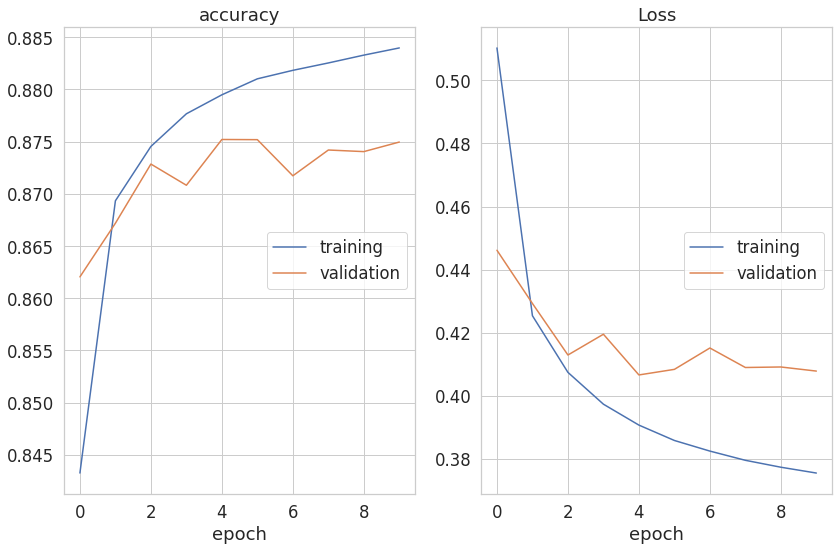

accuracy
	training         	 (min:    0.843, max:    0.884, cur:    0.884)
	validation       	 (min:    0.862, max:    0.875, cur:    0.875)
Loss
	training         	 (min:    0.376, max:    0.510, cur:    0.376)
	validation       	 (min:    0.407, max:    0.446, cur:    0.408)


In [25]:
!pip install livelossplot
from livelossplot import PlotLossesKerasTF

epochs = 10 
batch_size = 64
history = model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[PlotLossesKerasTF()],)

## Wizualizacja historii treningu

Przygotuj wykres na którym pokażesz jak podczas treningu zmieniało się training i validation accuracy.

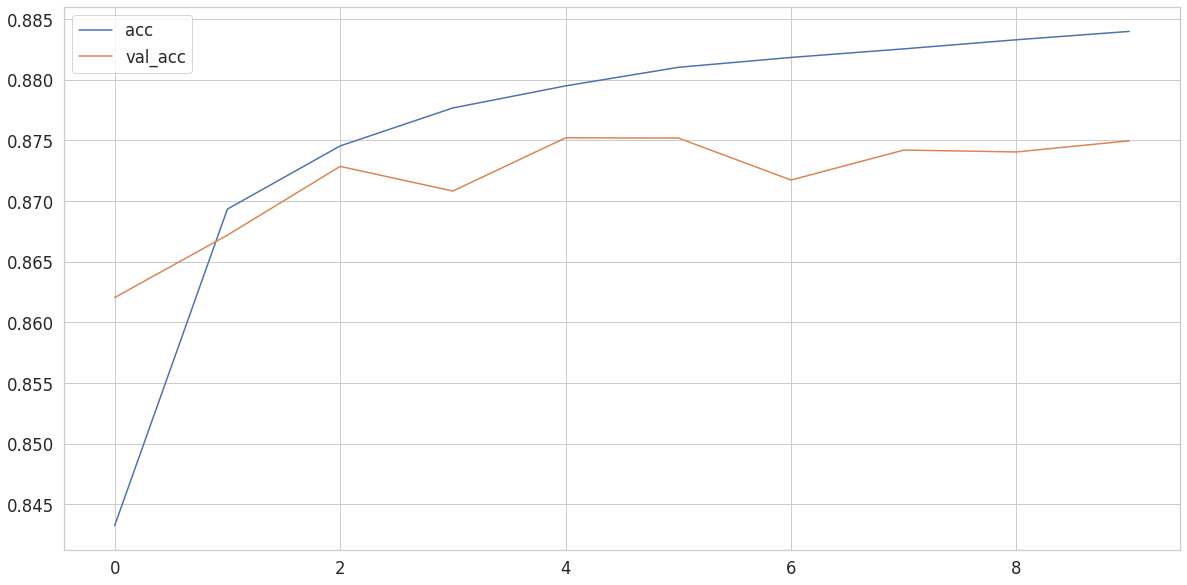

In [26]:
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

### Test

In [27]:
assert list(history.history.keys())==['loss', 'accuracy', 'val_loss', 'val_accuracy'], "Trening powinien być z walidacją oraz metryką accuracy"
assert len(history.history['loss'])==10, "Wystarczy 10 epok"

In [ ]:
# free GPU mem
del model

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.